In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sdv.single_table import TVAESynthesizer
from sdv.metadata import SingleTableMetadata
from sdv.single_table import CTGANSynthesizer

In [ ]:
# Load the data
data = pd.read_csv('Disable_Unsolicited_Messages_Attack_DNP3_Dataset_Attacker_02.csv')
print(data.shape)
data.head()
real_data = data


(2504, 7)


,flow ID,source IP,destination IP,source port,destination port,date,duration
0,192.168.1.11-192.168.1.9-34422-20002,192.168.1.11,192.168.1.9,34422,20002,14/05/2020 23:30:01,44018717
1,192.168.1.11-192.168.1.4-45060-20002,192.168.1.11,192.168.1.4,45060,20002,14/05/2020 23:30:01,44017770
2,192.168.1.11-192.168.1.8-39169-20002,192.168.1.11,192.168.1.8,39169,20002,14/05/2020 23:30:01,44018403
3,192.168.1.11-192.168.1.5-39574-20002,192.168.1.11,192.168.1.5,39574,20002,14/05/2020 23:30:01,44017756
4,192.168.1.11-192.168.1.3-33783-20002,192.168.1.11,192.168.1.3,33783,20002,14/05/2020 23:30:01,44018237


In [ ]:
#### DONT RUN IT AGAIN


# #CTGAN for generating synthetic data
# metadata = SingleTableMetadata()
# metadata.detect_from_dataframe(data)

# synthesizer = CTGANSynthesizer(metadata)
# synthesizer.fit(data)
# samples = synthesizer.sample(len(data))
# samples.head()

# # Save the synthetic data
# samples.to_csv('synthetic_ctgan_data.csv', index=False)

In [6]:
# load the synthetic data
synthetic_data = pd.read_csv('synthetic_ctgan_data.csv')

In [ ]:
#samples.head()

,flow ID,source IP,destination IP,source port,destination port,date,duration
0,192.168.1.11-192.168.1.3-33783-20002,192.168.1.11,192.168.1.3,33783,20002,14/05/2020 23:35:16,44025307
1,192.168.1.11-192.168.1.7-41065-20002,192.168.1.11,192.168.1.7,41065,20002,14/05/2020 23:59:17,44017195
2,192.168.1.11-192.168.1.3-33783-20002,192.168.1.11,192.168.1.3,33783,20002,15/05/2020 02:42:14,44008614
3,192.168.1.11-192.168.1.8-39169-20002,192.168.1.11,192.168.1.8,39169,20002,14/05/2020 23:47:02,44013817
4,192.168.1.11-192.168.1.7-41065-20002,192.168.1.11,192.168.1.7,41065,20002,15/05/2020 00:59:19,44012261


In [6]:
# evaluate the synthetic data
#1. duplicates or new
# Check if any row in synthetic data is exactly the same as a row in real data
duplicates_in_synthetic = samples[samples.apply(lambda row: row.tolist() in data.values.tolist(), axis=1)]

if len(duplicates_in_synthetic) > 0:
    print(f"Found {len(duplicates_in_synthetic)} duplicate rows in synthetic data.")
else:
    print("No exact duplicates found between synthetic and real data.")

No exact duplicates found between synthetic and real data.


In [7]:
import scipy.stats as stats

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

categorical_columns = ['flow ID', 'source IP', 'destination IP', 'source port', 'destination port', 'date']
correlation_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns)

for col1 in categorical_columns:
    for col2 in categorical_columns:
        correlation_matrix.loc[col1, col2] = cramers_v(data[col1], data[col2])

print(correlation_matrix)

                 flow ID source IP destination IP source port  \
flow ID              1.0    0.9986            1.0         1.0   
source IP         0.9986    0.4995         0.9986      0.9986   
destination IP       1.0    0.9986            1.0         1.0   
source port          1.0    0.9986            1.0         1.0   
destination port  0.9986    0.4995         0.9986      0.9986   
date                 0.0  0.473941            0.0         0.0   

                 destination port      date  
flow ID                    0.9986       0.0  
source IP                  0.4995  0.473941  
destination IP             0.9986       0.0  
source port                0.9986       0.0  
destination port           0.4995  0.473941  
date                     0.473941       1.0  


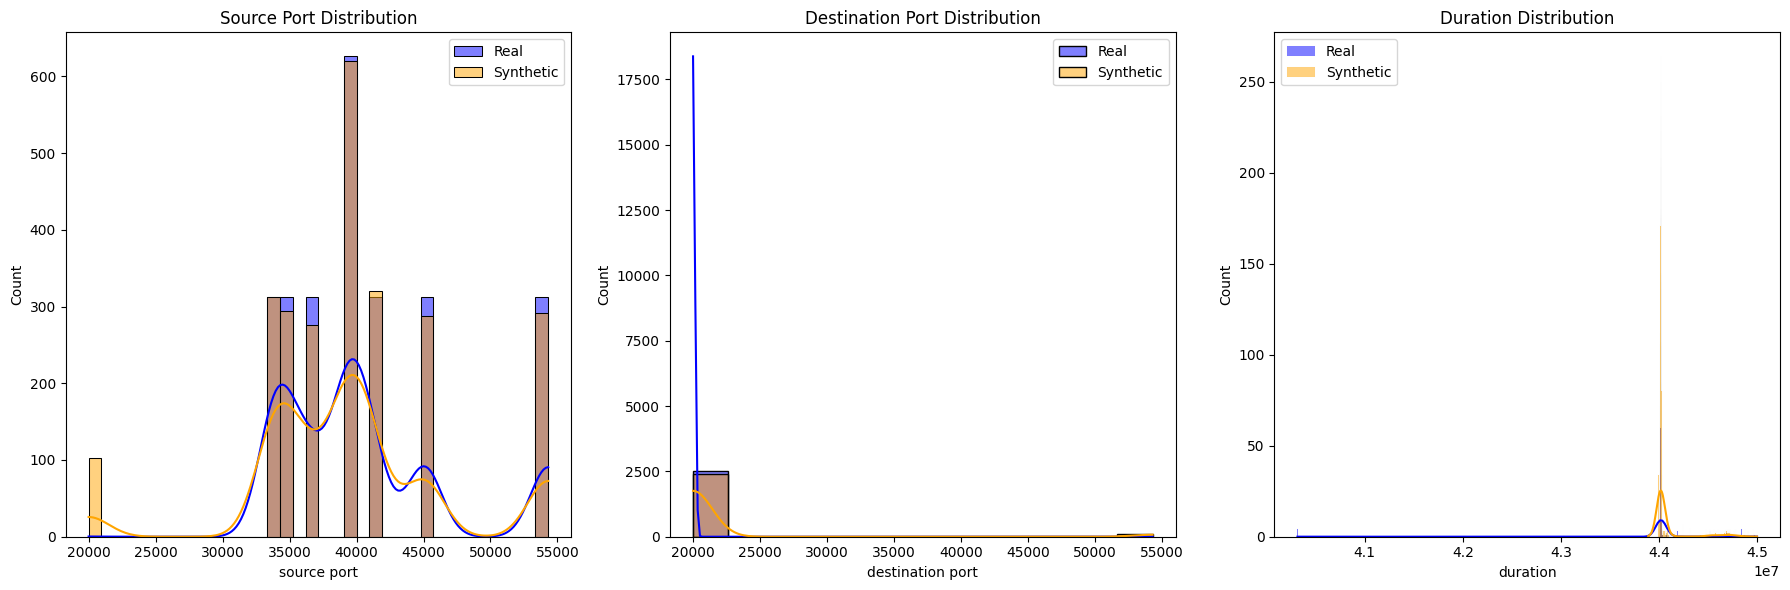

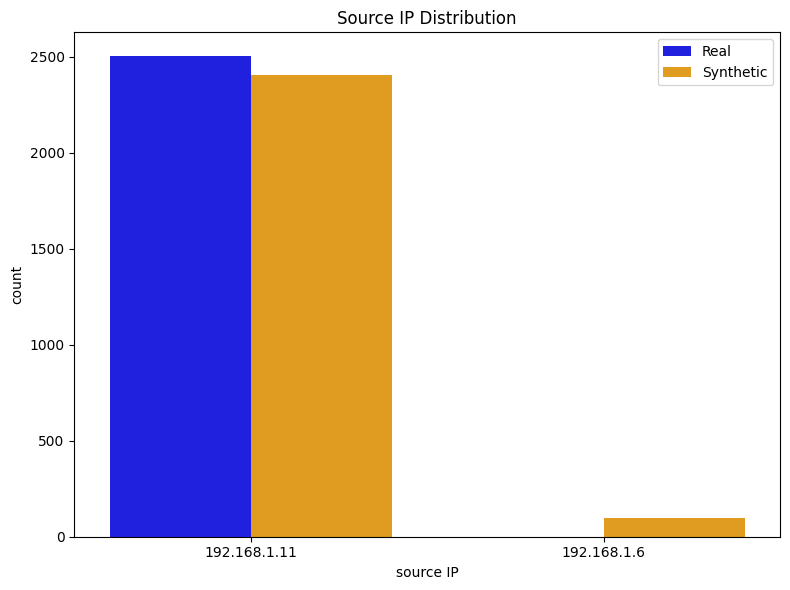

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Histograms for numerical variables
plt.figure(figsize=(18, 6))

# Source Port Distribution
plt.subplot(1, 3, 1)
sns.histplot(data['source port'], label='Real', kde=True, color='blue')
sns.histplot(samples['source port'], label='Synthetic', kde=True, color='orange')
plt.title('Source Port Distribution')
plt.legend()

# Destination Port Distribution
plt.subplot(1, 3, 2)
sns.histplot(data['destination port'], label='Real', kde=True, color='blue')
sns.histplot(samples['destination port'], label='Synthetic', kde=True, color='orange')
plt.title('Destination Port Distribution')
plt.legend()

# Duration Distribution
plt.subplot(1, 3, 3)
sns.histplot(data['duration'], label='Real', kde=True, color='blue')
sns.histplot(samples['duration'], label='Synthetic', kde=True, color='orange')
plt.title('Duration Distribution')
plt.legend()

plt.tight_layout()
plt.show()

# Bar plot for Source IP
# Combine real and synthetic data for bar plot
data['Label'] = 'Real'
samples['Label'] = 'Synthetic'
combined_data = pd.concat([data, samples])

# Create a new figure for the bar plot
plt.figure(figsize=(8, 6))
sns.countplot(x='source IP', data=combined_data, hue='Label', palette={'Real': 'blue', 'Synthetic': 'orange'})
plt.title('Source IP Distribution')
plt.legend()
plt.tight_layout()
plt.show()

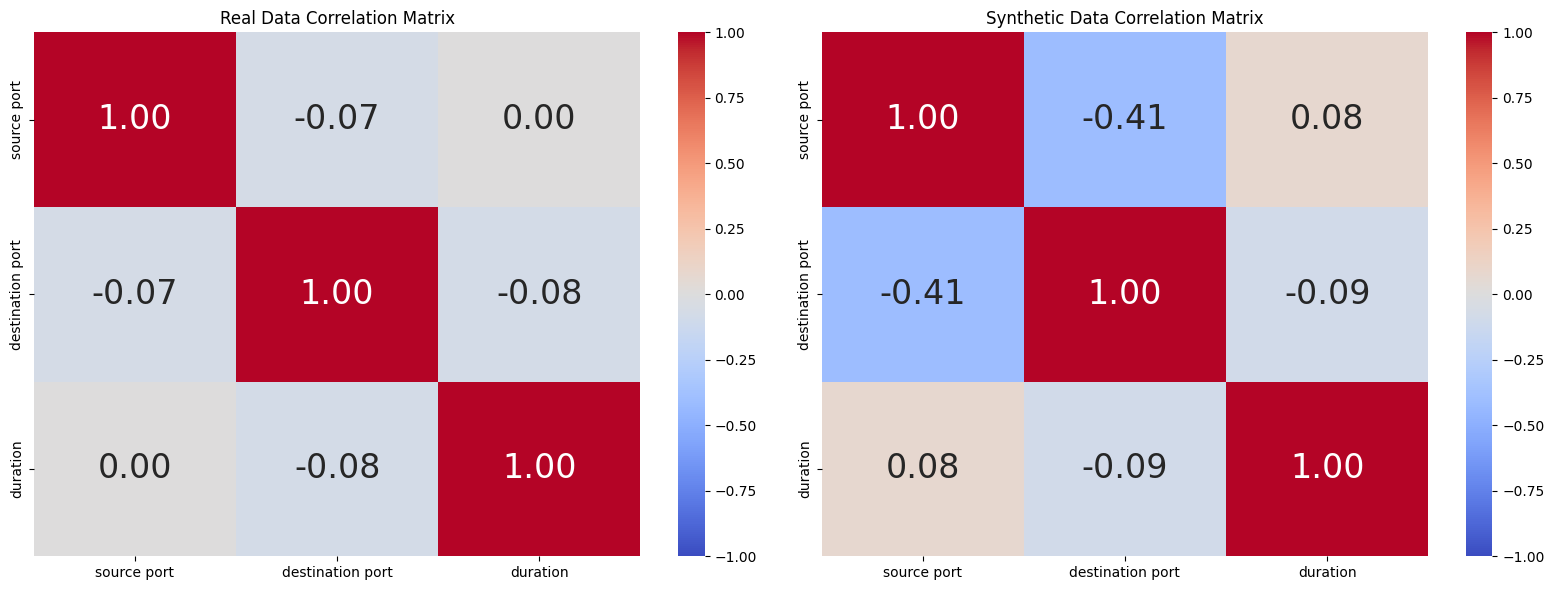

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select numerical columns
numerical_real = real_data.select_dtypes(include=[np.number])
numerical_synthetic = synthetic_data.select_dtypes(include=[np.number])

# Compute correlation matrices
real_corr = numerical_real.corr()
synthetic_corr = numerical_synthetic.corr()

# Plot side by side
plt.figure(figsize=(16, 6))

# Real data correlation
plt.subplot(1, 2, 1)
sns.heatmap(real_corr, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1, annot_kws={"size": 24})
plt.title('Real Data Correlation Matrix')

# Synthetic data correlation
plt.subplot(1, 2, 2)
sns.heatmap(synthetic_corr, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1, annot_kws={"size": 24})
plt.title('Synthetic Data Correlation Matrix')

plt.tight_layout()
plt.show()

In [16]:
real_corr

,source port,destination port,duration
source port,1.000000,-0.065365,0.001262
destination port,-0.065365,1.000000,-0.076918
duration,0.001262,-0.076918,1.000000


In [19]:
synthetic_corr

,source port,destination port,duration
source port,1.000000,-0.408742,0.075827
destination port,-0.408742,1.000000,-0.090353
duration,0.075827,-0.090353,1.000000


C:\Users\daf\AppData\Local\Temp\ipykernel_35560\3801393291.py:9: RuntimeWarning:

invalid value encountered in scalar divide

C:\Users\daf\AppData\Local\Temp\ipykernel_35560\3801393291.py:9: RuntimeWarning:

invalid value encountered in scalar divide

C:\Users\daf\AppData\Local\Temp\ipykernel_35560\3801393291.py:9: RuntimeWarning:

invalid value encountered in scalar divide

C:\Users\daf\AppData\Local\Temp\ipykernel_35560\3801393291.py:9: RuntimeWarning:

invalid value encountered in scalar divide

C:\Users\daf\AppData\Local\Temp\ipykernel_35560\3801393291.py:9: RuntimeWarning:

invalid value encountered in scalar divide

C:\Users\daf\AppData\Local\Temp\ipykernel_35560\3801393291.py:9: RuntimeWarning:

invalid value encountered in scalar divide

C:\Users\daf\AppData\Local\Temp\ipykernel_35560\3801393291.py:9: RuntimeWarning:

invalid value encountered in scalar divide

C:\Users\daf\AppData\Local\Temp\ipykernel_35560\3801393291.py:9: RuntimeWarning:

invalid value encountered in scalar 

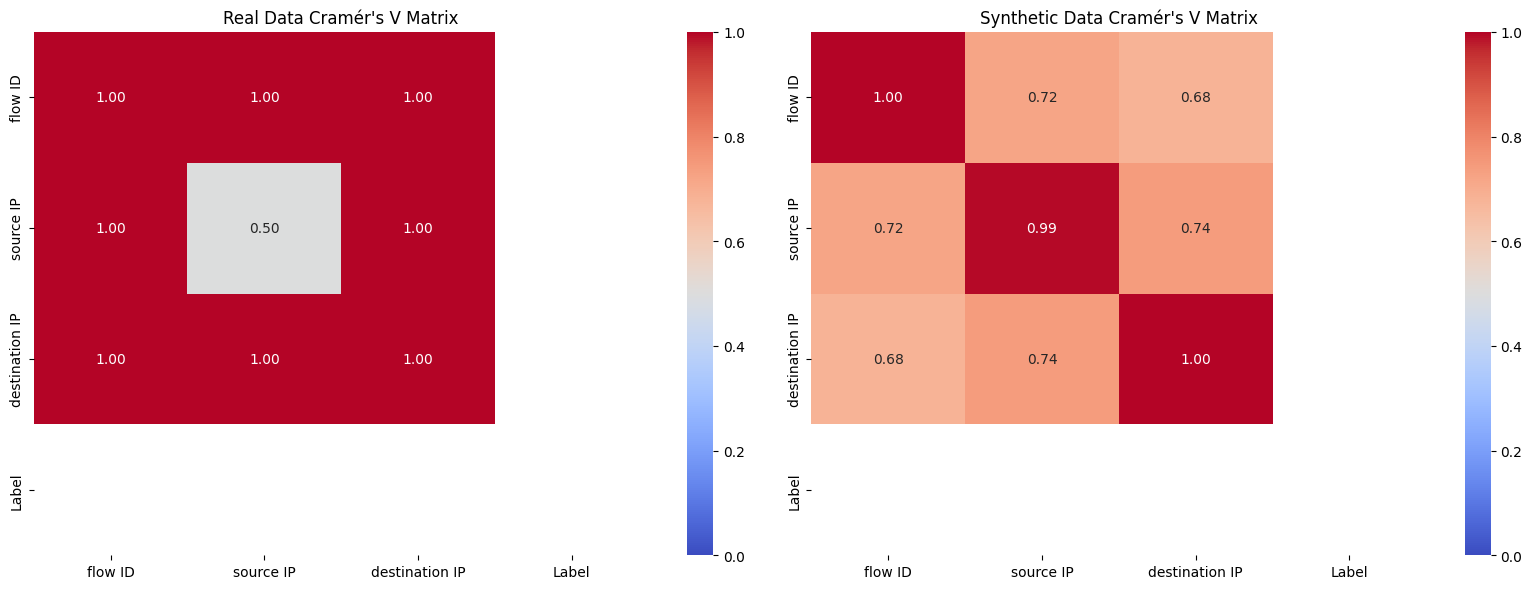

In [17]:
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min((k-1), (r-1)))

# Select categorical columns
categorical_real = real_data.select_dtypes(include=['object', 'category'])
categorical_synthetic = synthetic_data.select_dtypes(include=['object', 'category'])

# Compute Cramér’s V matrices
real_cramers = pd.DataFrame(index=categorical_real.columns, columns=categorical_real.columns)
synthetic_cramers = pd.DataFrame(index=categorical_synthetic.columns, columns=categorical_synthetic.columns)

for col1 in categorical_real.columns:
    for col2 in categorical_real.columns:
        real_cramers.loc[col1, col2] = cramers_v(categorical_real[col1], categorical_real[col2])

for col1 in categorical_synthetic.columns:
    for col2 in categorical_synthetic.columns:
        synthetic_cramers.loc[col1, col2] = cramers_v(categorical_synthetic[col1], categorical_synthetic[col2])

# Plot side by side
plt.figure(figsize=(16, 6))

# Real data Cramér’s V
plt.subplot(1, 2, 1)
sns.heatmap(real_cramers.astype(float), annot=True, cmap='coolwarm', fmt='.2f', vmin=0, vmax=1)
plt.title("Real Data Cramér's V Matrix")

# Synthetic data Cramér’s V
plt.subplot(1, 2, 2)
sns.heatmap(synthetic_cramers.astype(float), annot=True, cmap='coolwarm', fmt='.2f', vmin=0, vmax=1)
plt.title("Synthetic Data Cramér's V Matrix")

plt.tight_layout()
plt.show()